# **Deep Learning Project**

## **Phase 3**



*   Sobhan Asasi    
(400206392)
*   Mohammad Hajipour   
(401301843)
*   Amin Robatian   
(400301075)




# Requirements

In [1]:
# !pip install pycm
# !pip install torchtext
# !pip install transformers
# !pip install face_recognition

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import gc

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe

from transformers import BertTokenizer
from transformers import BertModel

import pickle
import os

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import ast
import math

import itertools
import re
import os
import contextlib
from typing import Any, Callable, Dict, IO, Iterable, Iterator, List, Optional, Tuple, TypeVar
import requests
from torch.utils.model_zoo import tqdm
import zipfile

import glob

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

import warnings
warnings.filterwarnings('ignore')

import scipy
from collections import Counter
from tqdm import tqdm
import re 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from pycm import *

Using cuda device


In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Download Dataset Functions

In [4]:
def create_dataset_directory(root, dataset_name):
        
        filename_dict = {'train':'train.zip',
                         'dev':'dev.zip',
                         'test':'test.zip',
                         'MSCTD_data_train':'MSCTD_data_train.zip',
                         'MSCTD_data_dev':'MSCTD_data_dev.zip',
                         'MSCTD_data_test':'MSCTD_data_test.zip'}
        
        id_dict = {'train':'156yOz7M1sAfz4RK6OEQoPsaaPOMhrsT6',
                   'dev':'1URhTfBeUQiAmzb_2gxtn4MCXUxFywGnR',
                   'test':'1MbzM9Twe5KCWAKwZYvZO_OK-v8qRVSPF',
                   'MSCTD_data_train':'1AEwXhfMApCWzGyGr6KRzPtx7hBy3jZXt',
                   'MSCTD_data_dev': '1h3YnPZlIdSqPsggoms1zK2ZF5enSBcDH',
                   'MSCTD_data_test':'1pYWqfTd9rZuQuKgL0wv34Ybz5OINI6SV'}
        
        isExist = os.path.exists(os.path.join(root, dataset_name))
        
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(os.path.join(root, dataset_name))
            print("The " +dataset_name+ " directory is created!")
            print('Downloading ...')
            download_file_from_google_drive(id_dict['MSCTD_data_'+dataset_name],
                                            os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]))
            download_file_from_google_drive(id_dict[dataset_name],
                                os.path.join(root, dataset_name, filename_dict[dataset_name]))
            
            _extract_zip(os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]),os.path.join(root, dataset_name))
            _extract_zip(os.path.join(root, dataset_name, filename_dict[dataset_name]),os.path.join(root, dataset_name))
            
        if(dataset_name=='train'):
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0]+'_ende')]
        else:
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0])]
        
        return list_path_out


def download_file_from_google_drive(file_id: str, fpath: str):
    """Download a Google Drive file from  and place it in root.
    Args:
        file_id (str): id of file to be downloaded
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the id of the file.
    """

    url = "https://drive.google.com/uc"
    params = dict(id=file_id, export="download")
    with requests.Session() as session:
        response = session.get(url, params=params, stream=True)

        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                token = value
                break
        else:
            api_response, content = _extract_gdrive_api_response(response)
            token = "t" if api_response == "Virus scan warning" else None

        if token is not None:
            response = session.get(url, params=dict(params, confirm=token), stream=True)
            api_response, content = _extract_gdrive_api_response(response)

        if api_response == "Quota exceeded":
            raise RuntimeError(
                f"The daily quota of the file {fpath} is exceeded and it "
                f"can't be downloaded. This is a limitation of Google Drive "
                f"and can only be overcome by trying again later."
            )

        _save_response_content(content, fpath)

    # In case we deal with an unhandled GDrive API response, the file should be smaller than 10kB and contain only text
    if os.stat(fpath).st_size < 10 * 1024:
        with contextlib.suppress(UnicodeDecodeError), open(fpath) as fh:
            text = fh.read()
            # Regular expression to detect HTML. Copied from https://stackoverflow.com/a/70585604
            if re.search(r"</?\s*[a-z-][^>]*\s*>|(&(?:[\w\d]+|#\d+|#x[a-f\d]+);)", text):
                warnings.warn(
                    f"We detected some HTML elements in the downloaded file. "
                    f"This most likely means that the download triggered an unhandled API response by GDrive. "
                    f"Please report this to torchvision at https://github.com/pytorch/vision/issues including "
                    f"the response:\n\n{text}"
                )

def _extract_gdrive_api_response(response, chunk_size: int = 32 * 1024) -> Tuple[bytes, Iterator[bytes]]:
    content = response.iter_content(chunk_size)
    first_chunk = None
    # filter out keep-alive new chunks
    while not first_chunk:
        first_chunk = next(content)
    content = itertools.chain([first_chunk], content)

    try:
        match = re.search("<title>Google Drive - (?P<api_response>.+?)</title>", first_chunk.decode())
        api_response = match["api_response"] if match is not None else None
    except UnicodeDecodeError:
        api_response = None
    return api_response, content


def _save_response_content(
    content: Iterator[bytes],
    destination: str,
    length: Optional[int] = None,
) -> None:
    with open(destination, "wb") as fh, tqdm(total=length) as pbar:
        for chunk in content:
            # filter out keep-alive new chunks
            if not chunk:
                continue

            fh.write(chunk)
            pbar.update(len(chunk))


def _extract_zip(from_path: str, to_path: str) -> None:
    with zipfile.ZipFile(
        from_path, "r", compression=zipfile.ZIP_STORED
    ) as zip:
        zip.extractall(to_path)


In [5]:
def files_to_dataframe(text_add, sentiment_add, index_add):
    """
    This function convert all necessary .txt files to a single dataframe

    Args :
    text_add : .txt of chats.
    sentiment_add : .txt of emotions for each line.
    index_add : .txt of related images for each line.

    Output -> pd.dataframe

    """
    df_text = pd.read_csv(text_add, delimiter = "\r\t", header=None, engine='python')
    df_text.columns = ['text']

    df_sentiment = pd.read_csv(sentiment_add, delimiter = "\t", header=None)
    df_sentiment.columns = ['label']

    df_index = pd.read_csv(index_add, delimiter = "\t", header=None)
    df_index.columns = ['indexes']

    #concatenation
    lst = [df_text, df_sentiment, df_index]
    df_result = pd.concat(lst, axis =1)

    return df_result

---
# Part (1) - Combination of Image & Text Modalities

# Part (1-1) - Concatenation

In [6]:
#  BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
max_length = 15

### Create Dataset Class

In [7]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', img_transform=None, text_transform=None, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.img_transform = img_transform
        self.text_transform = text_transform
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        label = np.array(label)
        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)
        
        if self.img_transform:
            img = self.img_transform(img)
            
        if self.text_transform:
            tokenized_text = tokenizer(text, padding='max_length',
                                       max_length=max_length, truncation=True, return_tensors="pt")
        
        sample = {
            'text': tokenized_text,
            'img': img,
            'label': label
        }
        return sample

In [8]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset =  MSCTDDataset(root='./data1', dataset_name='train',
                              img_transform=img_transform, text_transform='BertTokenizer')
dev_dataset =  MSCTDDataset(root='./data1', dataset_name='dev',
                            img_transform=img_transform, text_transform='BertTokenizer')
test_dataset =  MSCTDDataset(root='./data1', dataset_name='test',
                             img_transform=img_transform, text_transform='BertTokenizer')

print(f'The number of images in train datset is {len(train_dataset):,}')
print(f'The number of images in test datset is {len(test_dataset):,}')
print(f'The number of images in dev datset is {len(dev_dataset):,}')

The number of images in train datset is 20,240
The number of images in test datset is 5,067
The number of images in dev datset is 5,063


### Image Backbone

In [9]:
### Dataloader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                           shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)

In [10]:
gc.collect()
torch.cuda.empty_cache()

image_backbone = torchvision.models.resnet50(pretrained=True)

# Changing the requires grad of all layers to false
for param in image_backbone.parameters():
    param.requires_grad = False
    
# Change classifier layer
image_backbone.fc = nn.Sequential(
    nn.Linear(2048, 64),
    nn.ReLU(),
    nn.Linear(64,3)
)

pytorch_total_params = sum(p.numel() for p in image_backbone.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 131,331


In [11]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for batch, sample in tqdm(enumerate(train_dataloader)):
                
                label_img = sample['label'].to(device)
                
                input_img = sample['img'].to(device)

                output = model(input_img)
                
                batch_loss = criterion(output, label_img.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == label_img).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for batch, sample in tqdm(enumerate(val_dataloader)):

                    label_img = sample['label'].to(device)

                    input_img = sample['img'].to(device)

                    output = model(input_img)

                    batch_loss = criterion(output, label_img.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == label_img).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {100 * total_acc_train / len(train_dataset): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {100 * total_acc_val / len(dev_dataset): .2f}%')

In [12]:
EPOCHS = 2
LR = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_backbone.parameters(), lr= LR)

# sgd_opt = torch.optim.SGD(image_backbone.parameters(), lr=sgd_learning_rate, momentum=0.9)

train(image_backbone, train_dataloader, dev_dataloader, EPOCHS, criterion, optimizer)

317it [01:56,  2.71it/s]
80it [00:26,  3.04it/s]


Epochs: 1 | Train Loss:  0.017                 | Train Accuracy:  39.11%                 | Val Loss:  0.017                 | Val Accuracy:  36.99%


317it [01:55,  2.75it/s]
80it [00:26,  3.07it/s]

Epochs: 2 | Train Loss:  0.017                 | Train Accuracy:  40.82%                 | Val Loss:  0.017                 | Val Accuracy:  37.07%


In [13]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for batch, sample in tqdm(enumerate(test_dataloader)):
            
            label_img = sample['label'].to(device).data.cpu().numpy()
            y_true.extend(label_img) # Save Truth
            
            input_img = sample['img'].to(device)
            
            output = model(input_img)
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

In [14]:
image_backbone.eval()
y_true, y_pred = evaluate(image_backbone, test_dataloader)

80it [00:26,  3.00it/s]


Accuracy: 37.89%

F1 score: 27.87%

Confusion Matrix:


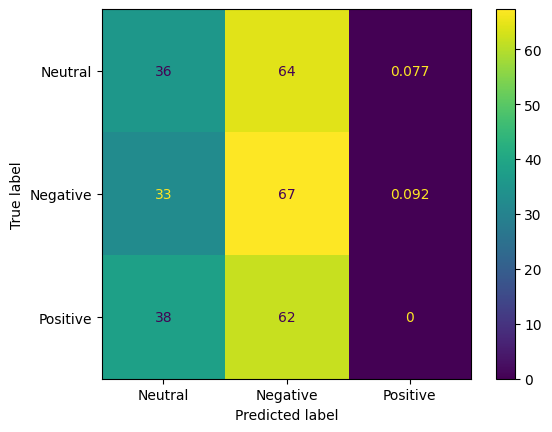

In [15]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix * 100, display_labels = [i for i in classes])
disp.plot()

### Text Backbone

In [16]:
### Dataloader
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
gc.collect()
torch.cuda.empty_cache()

class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.linear = nn.Linear(768, 3)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        linear_output = self.linear(pooled_output)

        return linear_output, pooled_output
    
text_backbone = BertClassifier()

pytorch_total_params = sum(p.numel() for p in text_backbone.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of Network's Parameters: 108,312,579


In [18]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for batch, sample in tqdm(enumerate(train_dataloader)):
                
                train_label = sample['label']
                train_input = sample['text']

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output, pooled_output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for batch, sample in tqdm(enumerate(val_dataloader)):
                    
                    val_label = sample['label']
                    val_input = sample['text']
                    
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output, pooled_output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {100 * total_acc_train / len(train_dataset): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {100 * total_acc_val / len(dev_dataset): .2f}%')

In [19]:
EPOCHS = 2
LR = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(text_backbone.parameters(), lr= LR)
              
train(text_backbone, train_dataloader, dev_dataloader, EPOCHS, criterion, optimizer)

633it [01:58,  5.35it/s]
159it [00:24,  6.47it/s]


Epochs: 1 | Train Loss:  0.028                 | Train Accuracy:  60.10%                 | Val Loss:  0.027                 | Val Accuracy:  60.42%


633it [01:58,  5.34it/s]
159it [00:24,  6.46it/s]

Epochs: 2 | Train Loss:  0.020                 | Train Accuracy:  74.73%                 | Val Loss:  0.030                 | Val Accuracy:  58.88%


In [20]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for batch, sample in tqdm(enumerate(test_dataloader)):
            
            test_label = sample['label']
            test_input = sample['text']

            test_label = test_label.to(device).data.cpu().numpy()
            y_true.extend(test_label) # Save Truth
                       
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output, pooled_output = model(input_id, mask)
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

In [21]:
text_backbone.eval()
y_true, y_pred = evaluate(text_backbone, test_dataloader)

159it [00:23,  6.73it/s]


Accuracy: 59.31%

F1 score: 57.80%

Confusion Matrix:


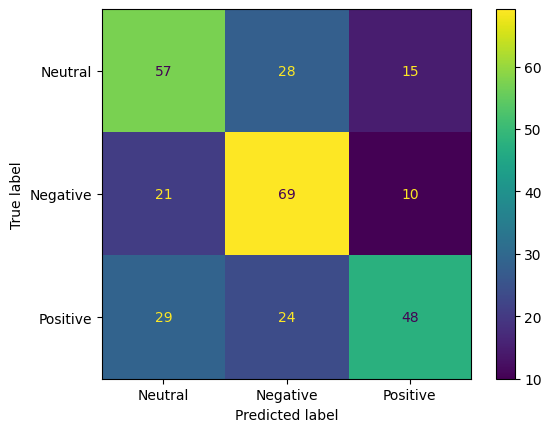

In [22]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix * 100, display_labels = [i for i in classes])
disp.plot()

### Text Backbone & Image Backbone 

In [23]:
image_backbone = nn.Sequential(*list(image_backbone.children())[:-1])

In [24]:
gc.collect()
torch.cuda.empty_cache()

class ImageTextMultiModalMlp(nn.Module):
    
    def __init__(self):
        super(ImageTextMultiModalMlp, self).__init__()
        
        
        for param in text_backbone.parameters():
            param.requires_grad = False
            
        for param in image_backbone.parameters():
            param.requires_grad = False
        
        self.backbone_txt = text_backbone
        self.backbone_img = image_backbone
        
        self.fc1 = nn.Linear(2048, 768)
        self.fc2 = nn.Linear(768*2, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 3)
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_id, mask, img):
        outt, x2 = self.backbone_txt(input_id, mask)
        x1 = self.backbone_img(img)
        x1 = torch.squeeze(x1, 2)
        x1 = torch.squeeze(x1, 2)
        x1 = self.fc1(x1)
        x = self.fc2(torch.cat((x1, x2), dim=1))
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.softmax(x)
        
        return x
    
model_final = ImageTextMultiModalMlp()

pytorch_total_params = sum(p.numel() for p in model_final.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 3,673,859


In [25]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for batch, sample in tqdm(enumerate(train_dataloader)):
                
                train_label = sample['label']
                train_input = sample['text']
                train_img = sample['img'].to(device)
                
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask, train_img)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for batch, sample in tqdm(enumerate(val_dataloader)):
                    
                    val_label = sample['label']
                    val_input = sample['text']
                    val_img = sample['img'].to(device)
                    
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask, val_img)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {100 * total_acc_train / len(train_dataset): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {100 * total_acc_val / len(dev_dataset): .2f}%')

In [26]:
EPOCHS = 2
LR = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_final.parameters(), lr= LR)
              
train(model_final, train_dataloader, dev_dataloader, EPOCHS, criterion, optimizer)

633it [02:03,  5.13it/s]
159it [00:26,  5.90it/s]


Epochs: 1 | Train Loss:  0.009                 | Train Accuracy:  90.21%                 | Val Loss:  0.040                 | Val Accuracy:  59.45%


633it [02:03,  5.11it/s]
159it [00:26,  5.90it/s]

Epochs: 2 | Train Loss:  0.008                 | Train Accuracy:  91.01%                 | Val Loss:  0.038                 | Val Accuracy:  59.13%


In [27]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for batch, sample in tqdm(enumerate(test_dataloader)):
            
            test_label = sample['label']
            test_input = sample['text']
            test_img = sample['img'].to(device)

            test_label = test_label.to(device).data.cpu().numpy()
            y_true.extend(test_label) # Save Truth
                       
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask, test_img)
            
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

In [28]:
model_final.eval()
y_true, y_pred = evaluate(model_final, test_dataloader)

159it [00:26,  5.91it/s]


Accuracy: 59.48%

F1 score: 58.39%

Confusion Matrix:


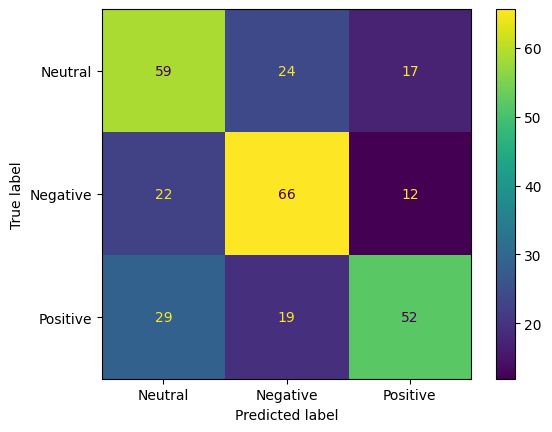

In [29]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix * 100, display_labels = [i for i in classes])
disp.plot()

### Results

*   By comparing the results of using the text backbone and image backbone and the concatenated form of these two models, it can be seen that the concatenated form works better than the text backbone and image backbone in an independent way and it is for the combination of the information from those modules.


# Part (1-2) - Pre-trained Transformer Backbones

In [56]:
#  BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
max_length = 15

## Create Datasetclass

In [57]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', img_transform=None, text_transform=None, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.img_transform = img_transform
        self.text_transform = text_transform
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        label = np.array(label)
        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)
        
        if self.img_transform:
            img = self.img_transform(img)
            
        if self.text_transform:
            tokenized_text = tokenizer(text, padding='max_length',
                                       max_length=max_length, truncation=True, return_tensors="pt")
        
        sample = {
            'text': tokenized_text,
            'img': img,
            'label': label
        }
        return sample

In [58]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset =  MSCTDDataset(root='./data1', dataset_name='train',
                              img_transform=img_transform, text_transform='BertTokenizer')
dev_dataset =  MSCTDDataset(root='./data1', dataset_name='dev',
                            img_transform=img_transform, text_transform='BertTokenizer')
test_dataset =  MSCTDDataset(root='./data1', dataset_name='test',
                             img_transform=img_transform, text_transform='BertTokenizer')

print(f'The number of images in train datset is {len(train_dataset):,}')
print(f'The number of images in test dataset is {len(test_dataset):,}')
print(f'The number of images in dev dataset is {len(dev_dataset):,}')

The number of images in train datset is 20,240
The number of images in test dataset is 5,067
The number of images in dev dataset is 5,063


## Dataloaders

In [59]:
### Dataloader
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                           shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)

In [60]:
for batch, sample in enumerate(train_dataloader):
    text = sample['text']
    ids = text['input_ids'].squeeze(1)
    masks = text['attention_mask'].squeeze(1)
    print(ids.shape, masks.shape)
    break

torch.Size([32, 15]) torch.Size([32, 15])


## Import neccessary libraries for pretrained transformers

In [61]:
from transformers import BertConfig
from transformers.modeling_utils import PreTrainedModel, prune_linear_layer

## Define Configs for training

In [62]:
config = BertConfig.from_pretrained("bert-base-uncased")

config.max_temporal_position_embeddings = 100
config.backbone_channel_in_size = 2048
config.max_grid_row_position_embeddings = 100
config.max_grid_col_position_embeddings = 100
config.attention_probs_dropout_prob = 0.1
config.hidden_act = "relu"
config.hidden_dropout_prob = 0.1
config.hidden_size= 768
config.initializer_range= 0.02
config.intermediate_size= 3072
config.layer_norm_eps= 1e-12
config.max_position_embeddings= 512
config.model_type= "bert"
config.num_attention_heads= 12
config.num_hidden_layers= 12
config.pad_token_id= 0
config.type_vocab_size= 2
config.vocab_size= 30522
config.cls_hidden_scale= 2  # mlp intermediate layer hidden size scaler
config.classifier="mlp"  # classfied type, [mlp, linear]
config.num_labels=3  # number of labels for classifier output
config.loss_type="ce"  # [BCE, CE, KLDivLoss] only used when num_labels > 1

In [63]:
def load_tf_weights_in_bert(model, config, tf_checkpoint_path):
    """ Load tf checkpoints in a pytorch model.
    """
    print('Load tf checkpoints in a pytorch model')
    try:
        import re
        import numpy as np
        import tensorflow as tf
    except ImportError:
        print(
            "Loading a TensorFlow model in PyTorch,"
            " requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ "
            "for installation instructions."
        )
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    print("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        print("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array)

    for name, array in zip(names, arrays):
        name = name.split("/")
        # adam_v and adam_m are variables used
        # in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(
            n in ["adam_v", "adam_m", "AdamWeightDecayOptimizer",
                  "AdamWeightDecayOptimizer_1", "global_step"]
            for n in name
        ):
            print("Skipping {}".format("/".join(name)))
            continue
        pointer = model
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+_\d+", m_name):
                scope_names = re.split(r"_(\d+)", m_name)
            else:
                scope_names = [m_name]
            if scope_names[0] == "kernel" or scope_names[0] == "gamma":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "output_bias" or scope_names[0] == "beta":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "output_weights":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "squad":
                pointer = getattr(pointer, "classifier")
            else:
                try:
                    pointer = getattr(pointer, scope_names[0])
                except AttributeError:
                    print("Skipping {}".format("/".join(name)))
                    continue
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]
        if m_name[-11:] == "_embeddings":
            pointer = getattr(pointer, "weight")
        elif m_name == "kernel":
            array = np.transpose(array)
        try:
            assert pointer.shape == array.shape
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        print("Initialize PyTorch weight {}".format(name))
        pointer.data = torch.from_numpy(array)
    return model


def mish(x):
    return x * torch.tanh(nn.functional.softplus(x))


# ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu,
#           "swish": swish, "gelu_new": gelu_new, "mish": mish}

ACT2FN = {"relu": torch.nn.functional.relu, "mish": mish}




## Define different parts of CLIP-BERT transformer

In [64]:
class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size,
            padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(
            config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with
        # TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids=None, token_type_ids=None,
                position_ids=None, inputs_embeds=None):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]
        device = input_ids.device if input_ids is not None\
            else inputs_embeds.device
        if position_ids is None:
            position_ids = torch.arange(
                seq_length, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand(input_shape)
        if token_type_ids is None:
            token_type_ids = torch.zeros(
                input_shape, dtype=torch.long, device=device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = (
            inputs_embeds + position_embeddings + token_type_embeddings)
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and\
                not hasattr(config, "embedding_size"):
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads)
            )
        self.output_attentions = config.output_attentions

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(
            config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        if encoder_hidden_states is not None:
            mixed_key_layer = self.key(encoder_hidden_states)
            mixed_value_layer = self.value(encoder_hidden_states)
            attention_mask = encoder_attention_mask
        else:
            mixed_key_layer = self.key(hidden_states)
            mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key"
        # to get the raw attention scores.
        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(
            self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is
            # (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (
            self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs
                   ) if self.output_attentions else (context_layer,)
        return outputs


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        mask = torch.ones(self.self.num_attention_heads,
                          self.self.attention_head_size)
        heads = set(heads) - self.pruned_heads  # Convert to set and remove already pruned heads
        for head in heads:
            # Compute how many pruned heads are
            # before the head and move the index accordingly
            head = head - sum(1 if h < head else 0 for h in self.pruned_heads)
            mask[head] = 0
        mask = mask.view(-1).contiguous().eq(1)
        index = torch.arange(len(mask))[mask].long()

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(
            heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        self_outputs = self.self(
            hidden_states, attention_mask, head_mask,
            encoder_hidden_states, encoder_attention_mask
        )
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.is_decoder = config.is_decoder
        if self.is_decoder:
            self.crossattention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        self_attention_outputs = self.attention(
            hidden_states, attention_mask, head_mask)
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        if self.is_decoder and encoder_hidden_states is not None:
            cross_attention_outputs = self.crossattention(
                attention_output, attention_mask, head_mask,
                encoder_hidden_states, encoder_attention_mask
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:]  # add cross attentions if we output attention weights

        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        outputs = (layer_output,) + outputs
        return outputs


class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(
            config.num_hidden_layers)])

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):
        all_hidden_states = ()
        all_attentions = ()
        for i, layer_module in enumerate(self.layer):
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states, attention_mask, head_mask[i],
                encoder_hidden_states, encoder_attention_mask
            )
            hidden_states = layer_outputs[0]

            if self.output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        return outputs  # last-layer hidden state, (all hidden states), (all attentions)


class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(
            config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


class BertPreTrainingHeads(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score


class BertPreTrainedModel(PreTrainedModel):
    """ An abstract class to handle weights initialization and
        a simple interface for downloading and loading pretrained models.
    """

    config_class = BertConfig
    load_tf_weights = load_tf_weights_in_bert
    base_model_prefix = "bert"

    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(
                mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


## Feature Backbone extraction from image

In [65]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1,
            init_identity=False):
    """3x3 convolution with padding"""
    conv = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False,
                     dilation=dilation)
    if init_identity:
        """ init as identity kernel, not working yet
        0 0 0
        0 1 0
        0 0 0
        """
        identity_weight = conv.weight.new_zeros(3, 3)
        identity_weight[1, 1] = 1. / in_planes
        identity_weight = identity_weight.view(
            1, 1, 3, 3).expand(conv.weight.size())
        with torch.no_grad():
            conv.weight = nn.Parameter(identity_weight)
    return conv


img_model = torchvision.models.resnet50(pretrained=True)

for param in img_model.parameters():
    param.requires_grad = False

class GridFeatBackbone(nn.Module):
    def __init__(self, img_model):
        super(GridFeatBackbone, self).__init__()
        self.feature = nn.Sequential(*list(img_model.children())[:-2])

        self.grid_encoder = nn.Sequential(
            conv3x3(config.backbone_channel_in_size, config.hidden_size),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        bsz, c, h, w = x.shape

        res5_features = self.feature(x)
        # print(res5_features.shape)
        grid = self.grid_encoder(res5_features)

        #grid = self.grid_encoder(grid_feat_outputs)  # (B * n_frm, C, H, W)
        new_c, new_h, new_w = grid.shape[-3:]
        n_frms = 1
        # if n_frms != 0:
        grid = grid.view(bsz, n_frms, new_c, new_h, new_w)  # (B, n_frm, C, H, W)

        grid = grid.permute(0, 1, 3, 4, 2)  # (B, n_frm=3, H, W, C)
        return grid


In [66]:
test_input = torch.randn((16,3,224,224))
#test_output = model(test_input)
grid_feat = GridFeatBackbone(img_model)
test_output = grid_feat(test_input)
print(test_output.shape)

torch.Size([16, 1, 3, 3, 768])


## Embedding visual features

In [67]:
class VisualInputEmbedding(nn.Module):
    """
    Takes input of both image and video (multi-frame)
    """
    def __init__(self, config):
        super(VisualInputEmbedding, self).__init__()
        self.config = config

        # sequence embedding
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size)
        self.row_position_embeddings = nn.Embedding(
            config.max_grid_row_position_embeddings,
            config.hidden_size)
        self.col_position_embeddings = nn.Embedding(
            config.max_grid_col_position_embeddings,
            config.hidden_size)
        self.token_type_embeddings = nn.Embedding(1, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(
            config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, grid):
        """
        Args:
            grid: (B, n_frm, H, W, C), note that #frm can be 1

        Returns:

        """
#         print(grid.shape)
        bsz, _, _, _, hsz = grid.shape

        # temporal mean pooling
        grid = grid.mean(1)  # (B, H, W, d)
        grid = self.add_2d_positional_embeddings(grid)  # (B, H, W, d)
        # image token sequence
        visual_tokens = grid.view(bsz, -1, hsz)  # (B, H*W, d)

 
        visual_tokens_shape = visual_tokens.shape[:-1]  # (B, H*W)
        device = visual_tokens.device

        # image token type embeddings.
        token_type_ids = torch.zeros(
            visual_tokens_shape, dtype=torch.long, device=device)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        # embeddings = visual_tokens + position_embeddings + token_type_embeddings
        embeddings = visual_tokens + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings  # (B, H*W, d)

    def add_temporal_postion_embeddings(self, grid):
        """
        Args:
            grid: (B, n_frms, H, W, d)

        Returns:
            (B, n_frms, H, W, d)
        """
        n_frms, height, width, hsz = grid.shape[-4:]

        # add row-wise position embeddings
        temporal_position_ids = torch.arange(
            n_frms, dtype=torch.long, device=grid.device)  # (n_frms, )
        t_position_embeddings = self.temporal_position_embeddings(
            temporal_position_ids)  # (n_frms, d)
        new_shape = (1, n_frms, 1, 1, hsz)  # (1, n_frms, 1, 1, d)
        grid = grid + t_position_embeddings.view(
            *new_shape)  # broadcast automatically

        return grid

    def add_2d_positional_embeddings(self, grid):
        """
        Args:
            grid: (B, *, H, W, d)

        Returns:
            (B, *, H, W, d)
        """
        height, width, hsz = grid.shape[-3:]

        # add row-wise position embeddings
        row_position_ids = torch.arange(
            height, dtype=torch.long, device=grid.device)  # (H, )
        row_position_embeddings = self.row_position_embeddings(
            row_position_ids)  # (H, d)
        row_shape = (1, ) * (len(grid.shape) - 3) + (
            height, 1, hsz)  # (1, *1, H, 1, d)
        grid = grid + row_position_embeddings.view(
            *row_shape)  # broadcast automatically

        # add column-wise position embeddings
        col_position_ids = torch.arange(
            width, dtype=torch.long, device=grid.device)  # (W, )
        col_position_embeddings = self.col_position_embeddings(
            col_position_ids)  # (W, d)
        col_shape = (1, ) * (len(grid.shape) - 3) + (
            1, width, hsz)  # (1, *1, 1, W, d)
        grid = grid + col_position_embeddings.view(
            *col_shape)  # broadcast automatically
        return grid

In [68]:
test_input = torch.randn((16, 1, 3, 3, 768))
#test_output = model(test_input)
grid_feat = VisualInputEmbedding(config)
test_output = grid_feat(test_input)
print(test_output.shape)

torch.Size([16, 9, 768])


## Define Bert Pretrained Base Model

In [69]:
class ClipBertBaseModel(BertPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well
    as a decoder, in which case a layer of cross-attention is added between
    the self-attention layers, following the architecture described in `Attention is all you need`_ by Ashish Vaswani,
    Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the
    :obj:`is_decoder` argument of the configuration set to :obj:`True`; an
    :obj:`encoder_hidden_states` is expected as an input to the forward pass.

    .. _`Attention is all you need`:
        https://arxiv.org/abs/1706.03762

    config keys:
        text_model: str, text model name, default "bert-based-uncased"
        pretrained: bool, use pre-trained vision_model, default True
    """

    def __init__(self, config):
        super().__init__(config)
        self.config = config

        self.embeddings = BertEmbeddings(config)
        self.visual_embeddings = VisualInputEmbedding(config)
        self.encoder = BertEncoder(config) 
        self.pooler = BertPooler(config) # Classification 

        self.init_weights()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """ Prunes heads of the model.
            heads_to_prune: dict of {layer_num: list of heads to prune in this layer}
            See base class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(self, text_input_ids, visual_inputs, attention_mask):
        r"""Modified from BertModel
        text_input_ids: (B, Lt)
        visual_inputs: (B, #frame, H, W, C)
        attention_mask: (B, Lt)  with 1 indicates valid, 0 indicates invalid position.
        """
        input_shape = text_input_ids.size()
        device = text_input_ids.device

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.

        text_embedding_output = self.embeddings(
            input_ids=text_input_ids)  # (B, Lt, D)
        visual_embedding_output = self.visual_embeddings(
            visual_inputs)  # (B, Lv, d)
        visual_attention_mask = attention_mask.new_ones(
            visual_embedding_output.shape[:2])  # (B, Lv)
        attention_mask = torch.cat(
            [attention_mask, visual_attention_mask], dim=-1)  # (B, lt+Lv, d)
        embedding_output = torch.cat(
            [text_embedding_output, visual_embedding_output],
            dim=1)  # (B, Lt+Lv, d)

        extended_attention_mask: torch.Tensor =\
            self.get_extended_attention_mask(
                attention_mask, input_shape, device)
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=self.get_head_mask(
                None, self.config.num_hidden_layers)  # required input
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)

        outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)

## Define Bert for Classification

In [70]:
class ClipBertForSequenceClassification(BertPreTrainedModel):
    """
    Modified from BertForSequenceClassification to support oscar training.
    """
    def __init__(self, config):
        super(ClipBertForSequenceClassification, self).__init__(config)
        self.config = config

        self.bert = ClipBertBaseModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size,
                      config.hidden_size * 2),
            nn.ReLU(True),
            nn.Linear(config.hidden_size * 2, config.num_labels)
        )

        self.init_weights()

    def forward(self, text_input_ids, visual_inputs,
                text_input_mask, labels=None):
        outputs = self.bert(
            text_input_ids=text_input_ids,
            visual_inputs=visual_inputs,
            attention_mask=text_input_mask,  # (B, Lt) note this mask is text only!!!
        )
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        logits, loss = self.calc_loss(logits, labels)
        return dict(
            logits=logits,
            loss=loss
        )

    def calc_loss(self, logits, labels):
        logits = logits.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.LongTensor)
        if labels is not None:
            if self.config.num_labels == 1:  # regression
                loss_fct = MSELoss(reduction="none")
                # labels = labels.to(torch.float)
                loss = loss_fct(
                    logits.view(-1), labels.view(-1))
            else:
                if self.config.loss_type == 'bce':  # [VQA]
                    loss = instance_bce_with_logits(
                        logits, labels, reduction="none")
                elif self.config.loss_type == "ce":  # cross_entropy [GQA, Retrieval, Captioning]
                    loss_fct = nn.CrossEntropyLoss()
                    logits = logits.to(device)
                    labels = labels.to(device)
#                     print(logits)
#                     print(labels)
                    loss = loss_fct(
                        logits.view(-1, self.config.num_labels),
                        labels.view(-1))
                else:
                    raise ValueError("Invalid option for config.loss_type")
        else:
            loss = 0
#         print(loss.item())    
        return logits, loss

## Define final Clip-Bert Model

In [71]:
class ClipBert(nn.Module):
    def __init__(self, config, transformer_cls=ClipBertForSequenceClassification):
        super(ClipBert, self).__init__()
        self.config = config
        self.cnn = GridFeatBackbone(img_model)
        self.transformer = transformer_cls(self.config)


    def forward(self, batch):
    
        visual_features = self.cnn(batch["visual_inputs"])
        batch["visual_inputs"] = visual_features
        outputs = self.transformer(**batch)  # dict
        return outputs

    def load_separate_ckpt(self, cnn_weights_path=None, bert_weights_path=None):
        if cnn_weights_path:
            self.cnn.load_state_dict(cnn_weights_path)

        if bert_weights_path:
            load_state_dict_with_mismatch(self.transformer, bert_weights_path)

    def freeze_cnn_backbone(self):
        for n, p in self.cnn.feature.named_parameters():
            p.requires_grad = False

In [72]:
model = ClipBert(config)

## Structure of Model

In [73]:
print(model)

ClipBert(
  (cnn): GridFeatBackbone(
    (feature): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
    

## Number of parameters

In [74]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 125,372,931 trainable parameters


## Train and Validation Loop

In [75]:
def train_loop(dataloader, model, optimizer, results, device="cpu"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for num, sample in enumerate(dataloader):
        text = sample['text'].to(device)
        ids = text['input_ids'].squeeze(1).to(device)
        masks = text['attention_mask'].squeeze(1).to(device)
        y = sample['label'].to(device)
        batch = {
            'text_input_ids': ids,
            'visual_inputs': sample['img'].to(device),
            'text_input_mask': masks,
            'labels': y
        }
        output = model(batch)
        #print(pred.shape, y.shape)
        pred = output['logits']
#         loss = loss_fn(pred, y)
        loss = output['loss']
        train_loss += output['loss'].item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if num % 1000 == 0:
#             loss, current = loss.item(), num * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    results['train loss'].append(train_loss)
    results['train accuracy'].append(100*correct)
    print(f"Train Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    
def valid_loop(dataloader, model, results, device="cpu", mode="valid"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for num, sample in enumerate(dataloader):
            text = sample['text'].to(device)
            ids = text['input_ids'].squeeze(1).to(device)
            masks = text['attention_mask'].squeeze(1).to(device)
            y = sample['label'].to(device)
#             print(ids.shape, masks.shape)
            batch = {
                'text_input_ids': ids,
                'visual_inputs': sample['img'].to(device),
                'text_input_mask': masks,
                'labels': y
            }
            output = model(batch)
            pred = output['logits']
            test_loss += output['loss'].item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results['valid loss'].append(test_loss)
    results['valid accuracy'].append(100*correct)
    if mode == "valid":
        print(f"Validation Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    else:
        print(f"Test Metrics: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [76]:
def train_valid(train_loader, valid_loader, optimizer, results, model_name, model, epochs, device="cpu"):
    
    model.to(device)
    print(f"{model_name}\n-------------------------------")
    
    for t in range(1, epochs+1):
      results['epoch'].append(t+1)
      print(f"Epoch {t}\n-------------------------------")
      train_loop(train_loader, model, optimizer, results, device=device)
      valid_loop(valid_loader, model, results, device=device)

    print("Done!")
    
    

## Results on train and validation data

In [77]:
gc.collect()
torch.cuda.empty_cache()

lr = 3e-5
opt = torch.optim.Adam(model.parameters(), lr=lr) 
num_epochs = 5
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_dataloader, dev_dataloader, opt, results, model_name="CLIP-BERT", model=model, epochs=num_epochs, device=device)

CLIP-BERT
-------------------------------
Epoch 1
-------------------------------
Train Metrics: 
 Accuracy: 39.3%, Avg loss: 1.090585 

Validation Metrics: 
 Accuracy: 41.1%, Avg loss: 1.092042 

Epoch 2
-------------------------------
Train Metrics: 
 Accuracy: 46.9%, Avg loss: 1.049715 

Validation Metrics: 
 Accuracy: 44.4%, Avg loss: 1.081844 

Epoch 3
-------------------------------
Train Metrics: 
 Accuracy: 51.6%, Avg loss: 1.002915 

Validation Metrics: 
 Accuracy: 45.4%, Avg loss: 1.057531 

Epoch 4
-------------------------------
Train Metrics: 
 Accuracy: 56.0%, Avg loss: 0.950470 

Validation Metrics: 
 Accuracy: 47.8%, Avg loss: 1.059017 

Epoch 5
-------------------------------
Train Metrics: 
 Accuracy: 60.2%, Avg loss: 0.903525 

Validation Metrics: 
 Accuracy: 50.1%, Avg loss: 1.082430 

Done!


## Evaluation on test data

In [78]:
valid_loop(test_dataloader, model, results, device=device, mode="test")

Test Metrics: 
 Accuracy: 51.5%, Avg loss: 1.086818 



In [79]:
def evaluate(dataloader, model, device="cpu"):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for num, sample in enumerate(dataloader):
            text = sample['text'].to(device)
            ids = text['input_ids'].squeeze(1).to(device)
            masks = text['attention_mask'].squeeze(1).to(device)
            y = sample['label'].to(device)
            y_true.extend(y.data.cpu().tolist())
#             print(ids.shape, masks.shape)
            batch = {
                'text_input_ids': ids,
                'visual_inputs': sample['img'].to(device),
                'text_input_mask': masks,
                'labels': y
            }
            output = model(batch)
            pred = output['logits']
            y_pred.extend(pred.argmax(1).data.cpu().tolist())
            test_loss += output['loss'].item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    return y_true, y_pred

In [80]:
y_true, y_pred = evaluate(test_dataloader, model, device=device)

Accuracy: 51.47%

F1 score: 48.63%

Confusion Matrix:


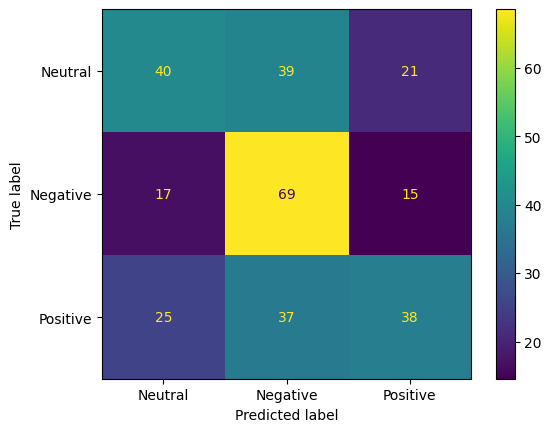

In [81]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix * 100, display_labels = [i for i in classes])
disp.plot()

## Results

- In this section we extract visual and textual features then feed these features to the SOTA transformer as a backbone.
- Acoording to the result we have comparable metrics with previous section.
- As the results show, the amount of overfitting decreased.

---
# Part (2) - Multimodal Data for Weakly Supervised Learning

# Part (2-1)

In [82]:
#  BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
max_length = 15

### Create Dataset Class

In [83]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', img_transform=None, text_transform=None, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.img_transform = img_transform
        self.text_transform = text_transform
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        label = np.array(label)
        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)
        
        if self.img_transform:
            img = self.img_transform(img)
            
        if self.text_transform:
            tokenized_text = tokenizer(text, padding='max_length',
                                       max_length=max_length, truncation=True, return_tensors="pt")
        
        sample = {
            'text': tokenized_text,
            'img': img,
            'label': label
        }
        return sample

In [84]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset =  MSCTDDataset(root='./data1', dataset_name='train',
                              img_transform=img_transform, text_transform='BertTokenizer')
dev_dataset =  MSCTDDataset(root='./data1', dataset_name='dev',
                            img_transform=img_transform, text_transform='BertTokenizer')
test_dataset =  MSCTDDataset(root='./data1', dataset_name='test',
                             img_transform=img_transform, text_transform='BertTokenizer')

print(f'The number of images in train datset is {len(train_dataset):,}')
print(f'The number of images in test dataset is {len(test_dataset):,}')
print(f'The number of images in dev dataset is {len(dev_dataset):,}')

The number of images in train datset is 20,240
The number of images in test dataset is 5,067
The number of images in dev dataset is 5,063


### Image Backbone

In [85]:
### Dataloader
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                           shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)

In [86]:
gc.collect()
torch.cuda.empty_cache()

image_backbone = torchvision.models.resnet50(pretrained=True)

# Changing the requires grad of all layers to false
for param in image_backbone.parameters():
    param.requires_grad = False
    
# Change classifier layer
image_backbone.fc = nn.Sequential(
    nn.Linear(2048, 64),
    nn.ReLU(),
    nn.Linear(64,3)
)

pytorch_total_params = sum(p.numel() for p in image_backbone.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Number of Network's Parameters: 131,331


In [87]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for batch, sample in tqdm(enumerate(train_dataloader)):
                
                label_img = sample['label'].to(device)
                
                input_img = sample['img'].to(device)

                output = model(input_img)
                
                batch_loss = criterion(output, label_img.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == label_img).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for batch, sample in tqdm(enumerate(val_dataloader)):

                    label_img = sample['label'].to(device)

                    input_img = sample['img'].to(device)

                    output = model(input_img)

                    batch_loss = criterion(output, label_img.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == label_img).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {100 * total_acc_train / len(train_dataset): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {100 * total_acc_val / len(dev_dataset): .2f}%')

In [88]:
EPOCHS = 10
LR = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_backbone.parameters(), lr=LR)

# sgd_opt = torch.optim.SGD(image_backbone.parameters(), lr=sgd_learning_rate, momentum=0.9)

train(image_backbone, train_dataloader, dev_dataloader, EPOCHS, criterion, optimizer)

317it [01:55,  2.75it/s]
80it [00:25,  3.08it/s]


Epochs: 1 | Train Loss:  0.017                 | Train Accuracy:  38.78%                 | Val Loss:  0.017                 | Val Accuracy:  36.54%


317it [01:54,  2.76it/s]
80it [00:25,  3.08it/s]


Epochs: 2 | Train Loss:  0.017                 | Train Accuracy:  40.96%                 | Val Loss:  0.017                 | Val Accuracy:  36.97%


317it [01:54,  2.76it/s]
80it [00:25,  3.08it/s]


Epochs: 3 | Train Loss:  0.017                 | Train Accuracy:  41.31%                 | Val Loss:  0.017                 | Val Accuracy:  36.58%


317it [01:55,  2.75it/s]
80it [00:25,  3.08it/s]


Epochs: 4 | Train Loss:  0.017                 | Train Accuracy:  41.74%                 | Val Loss:  0.017                 | Val Accuracy:  37.07%


317it [01:55,  2.76it/s]
80it [00:25,  3.08it/s]


Epochs: 5 | Train Loss:  0.017                 | Train Accuracy:  42.08%                 | Val Loss:  0.017                 | Val Accuracy:  35.51%


317it [01:54,  2.76it/s]
80it [00:25,  3.08it/s]


Epochs: 6 | Train Loss:  0.017                 | Train Accuracy:  42.73%                 | Val Loss:  0.017                 | Val Accuracy:  36.78%


317it [01:54,  2.76it/s]
80it [00:25,  3.08it/s]


Epochs: 7 | Train Loss:  0.017                 | Train Accuracy:  42.67%                 | Val Loss:  0.017                 | Val Accuracy:  36.07%


317it [01:55,  2.73it/s]
80it [00:26,  3.03it/s]


Epochs: 8 | Train Loss:  0.017                 | Train Accuracy:  43.65%                 | Val Loss:  0.017                 | Val Accuracy:  36.28%


317it [01:54,  2.76it/s]
80it [00:25,  3.08it/s]


Epochs: 9 | Train Loss:  0.017                 | Train Accuracy:  43.62%                 | Val Loss:  0.018                 | Val Accuracy:  37.03%


317it [01:54,  2.76it/s]
80it [00:25,  3.08it/s]

Epochs: 10 | Train Loss:  0.017                 | Train Accuracy:  44.42%                 | Val Loss:  0.017                 | Val Accuracy:  36.44%


In [89]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for batch, sample in tqdm(enumerate(test_dataloader)):
            
            label_img = sample['label'].to(device).data.cpu().numpy()
            y_true.extend(label_img) # Save Truth
            
            input_img = sample['img'].to(device)
            
            output = model(input_img)
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

In [90]:
image_backbone.eval()
y_true, y_pred = evaluate(image_backbone, test_dataloader)

80it [00:25,  3.11it/s]


Accuracy: 36.06%

F1 score: 29.88%

Confusion Matrix:


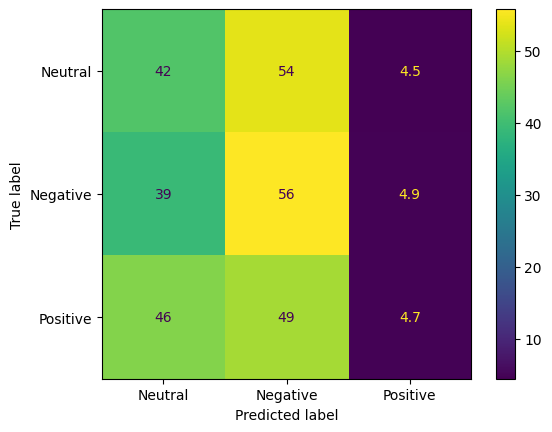

In [91]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix * 100, display_labels = [i for i in classes])
disp.plot()

### Text Backbone

In [92]:
### Dataloader
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [93]:
gc.collect()
torch.cuda.empty_cache()

class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.linear = nn.Linear(768, 3)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        linear_output = self.linear(pooled_output)

        return linear_output
    
text_backbone = BertClassifier()

pytorch_total_params = sum(p.numel() for p in text_backbone.parameters() if p.requires_grad)
print(f"Number of Network's Parameters: {pytorch_total_params:,}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of Network's Parameters: 108,312,579


In [94]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for batch, sample in tqdm(enumerate(train_dataloader)):
                
                train_label = sample['label']
                train_input = sample['text']

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for batch, sample in tqdm(enumerate(val_dataloader)):
                    
                    val_label = sample['label']
                    val_input = sample['text']
                    
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
                | Train Accuracy: {100 * total_acc_train / len(train_dataset): .2f}% \
                | Val Loss: {total_loss_val / len(dev_dataset): .3f} \
                | Val Accuracy: {100 * total_acc_val / len(dev_dataset): .2f}%')

In [95]:
EPOCHS = 2
LR = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(text_backbone.parameters(), lr= LR)
              
train(text_backbone, train_dataloader, dev_dataloader, EPOCHS, criterion, optimizer)

633it [01:58,  5.34it/s]
159it [00:23,  6.77it/s]


Epochs: 1 | Train Loss:  0.027                 | Train Accuracy:  60.93%                 | Val Loss:  0.027                 | Val Accuracy:  59.37%


633it [01:58,  5.34it/s]
159it [00:24,  6.47it/s]

Epochs: 2 | Train Loss:  0.020                 | Train Accuracy:  74.20%                 | Val Loss:  0.030                 | Val Accuracy:  59.12%


In [96]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for batch, sample in tqdm(enumerate(test_dataloader)):
            
            test_label = sample['label']
            test_input = sample['text']

            test_label = test_label.to(device).data.cpu().numpy()
            y_true.extend(test_label) # Save Truth
                       
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

In [97]:
text_backbone.eval()
y_true, y_pred = evaluate(text_backbone, test_dataloader)

159it [00:24,  6.47it/s]


Accuracy: 59.82%

F1 score: 58.37%

Confusion Matrix:


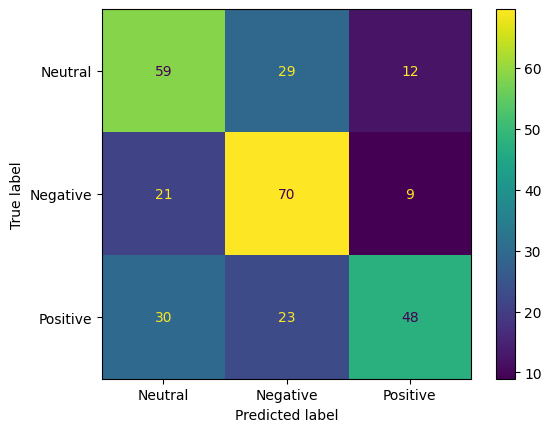

In [98]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix* 100, display_labels = [i for i in classes])
disp.plot()

# Part (2-2)

For this part, we use OpenViDial 1.0 Dataset as our "Unlabeld Dataset":
https://github.com/ShannonAI/OpenViDial

It contains a total number of 1.1 million dialogue turns, and thus 1.1 million visual contexts stored in images.

Due to the huge size of the dataset, we used only its test data, which contains 55,667 samples.


### Downloading Dataset & Preparation

In [99]:
## test_images.zip
#!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1DgZXlGi_x37nQrJYK4tSLXEvVShBKaZY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DgZXlGi_x37nQrJYK4tSLXEvVShBKaZY" -O test_images.zip && rm -rf /tmp/cookies.txt

In [100]:
## test.origin.txt
#!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Rv6CFwDGwiVjozO5JXdiIXeVKmnJR1RL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Rv6CFwDGwiVjozO5JXdiIXeVKmnJR1RL" -O test.origin.txt && rm -rf /tmp/cookies.txt

In [101]:
## Unzip
#!mkdir test_images
#!unzip test_images.zip -d /home/dllabsharif/DeepProject/MSCTD/test_images

### Preparing the Image & Text Backbones

In [102]:
gc.collect()
torch.cuda.empty_cache()

# Changing the requires grad of all layers to false
for param in text_backbone.parameters():
    param.requires_grad = False
    
pytorch_total_params = sum(p.numel() for p in text_backbone.parameters() if p.requires_grad)
print(f"Number of Text-Backbone Learnable Parameters: {pytorch_total_params:,}")

pytorch_total_params = sum(p.numel() for p in image_backbone.parameters() if p.requires_grad)
print(f"Number of Image-Backbone Learnable Parameters: {pytorch_total_params:,}")

Number of Text-Backbone Learnable Parameters: 0
Number of Image-Backbone Learnable Parameters: 131,331


### Unlabeled Dataset Class

In [103]:
df = pd.read_csv("test.origin.txt", sep=" \t ", header=None, names=["text"])
df

,text
0,Then you will not.
1,"You know what, I'm not going down like this."
2,I need you to untie me.
3,Julst untie me
4,"No, you heard Mr. Fine. He's working a plan."
...,...
55662,Why is everyone taller than me?
55663,"You know what, this is all in my head."
55664,"It's my problem, not yours."
55665,"Leonard, why do you always do this?"


In [104]:
class OpenViDial(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root='/home/dllabsharif/DeepProject/MSCTD/test_images', df=None,
                 img_transform=None, text_transform=None, random_state=42):
        

        self.dataframe = df
        self.img_dir = root
        self.img_transform = img_transform
        self.text_transform = text_transform
        
    def __len__(self):
        
        return 500
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        text = self.dataframe.loc[idx, 'text']

        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)
        
        if self.img_transform:
            img = self.img_transform(img)
            
        if self.text_transform:
            tokenized_text = tokenizer(text, padding='max_length',
                                       max_length=max_length, truncation=True, return_tensors="pt")
        
        sample = {
            'text': tokenized_text,
            'img': img,
            'original_text': text
        }
        return sample

In [105]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_unlabeled =  OpenViDial(df=df, img_transform=img_transform, text_transform='BertTokenizer')


print(f'The number of images/texts in Unlabeled Datset is {len(dataset_unlabeled):,}')

The number of images/texts in Unlabeled Datset is 500


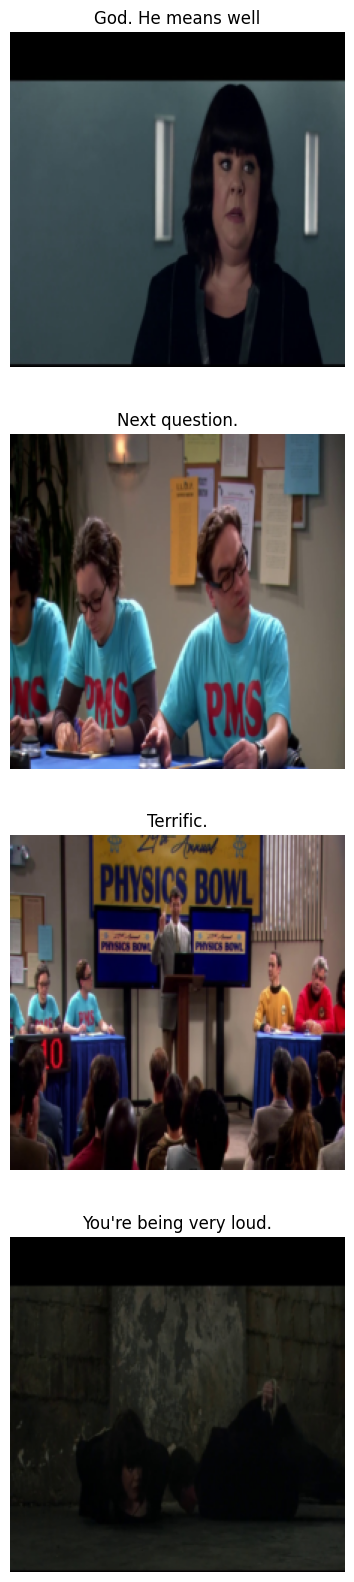

In [106]:
figure = plt.figure(figsize=(20, 20))
rows, cols = 4, 1

for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(dataset_unlabeled), size=(1,)).item()
    img  =  dataset_unlabeled[sample_idx]['img']
    img = img.permute(1, 2, 0)
    label = dataset_unlabeled[sample_idx]['original_text']
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img) 
    plt.imshow(img)  
    
plt.show()

### Dataloader

In [107]:
### Dataloader
batch_size = 64

unlabeled_dataloader = torch.utils.data.DataLoader(dataset=dataset_unlabeled, 
                                            batch_size=batch_size, 
                                           shuffle=True)

### Train Loop

In [108]:
def train(image_backbone, text_backbone, unlabeled_dataloader, epochs, criterion, optimizer):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

            image_backbone = image_backbone.cuda()
            text_backbone = text_backbone.cuda()

    for epoch_num in range(epochs):

            total_loss_train = 0

            for batch, sample in tqdm(enumerate(unlabeled_dataloader)):                    
                    
                text_input = sample['text']
                mask = text_input['attention_mask'].to(device)
                input_id = text_input['input_ids'].squeeze(1).to(device)
                text_output = text_backbone(input_id, mask)
                text_output = F.softmax(text_output, dim=1)
                
                img_input = sample['img'].to(device)
                img_output = image_backbone(img_input)
                img_output = F.log_softmax(img_output, dim=1)

                batch_loss = criterion(img_output, text_output)
                batch_loss.to(device)
                total_loss_train += batch_loss.item()
                

                image_backbone.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(dataset_unlabeled): .3f}')

### Training Network

For the cost function of this section, we used the KL Divergence to optimize the distance of image network labels from the distribution of text network labels.

In [109]:
EPOCHS = 2
LR = 1e-4
criterion = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(image_backbone.parameters(), lr= LR)

train(image_backbone, text_backbone, unlabeled_dataloader, EPOCHS, criterion, optimizer)

8it [00:03,  2.08it/s]


Epochs: 1 | Train Loss:  0.007


8it [00:02,  2.91it/s]

Epochs: 2 | Train Loss:  0.007


### Evaluate Loop

In [110]:
def evaluate(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():
        
        y_pred = []
        y_true = []

        for batch, sample in tqdm(enumerate(test_dataloader)):
            
            label_img = sample['label'].to(device).data.cpu().numpy()
            y_true.extend(label_img) # Save Truth
            
            input_img = sample['img'].to(device)
            
            output = model(input_img)
            output = output.argmax(dim=1).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
                
    return y_true, y_pred

### Evaluating Network

In [111]:
image_backbone.eval()
y_true, y_pred = evaluate(image_backbone, test_dataloader)

159it [00:25,  6.14it/s]


Accuracy: 39.91%

F1 score: 26.89%

Confusion Matrix:


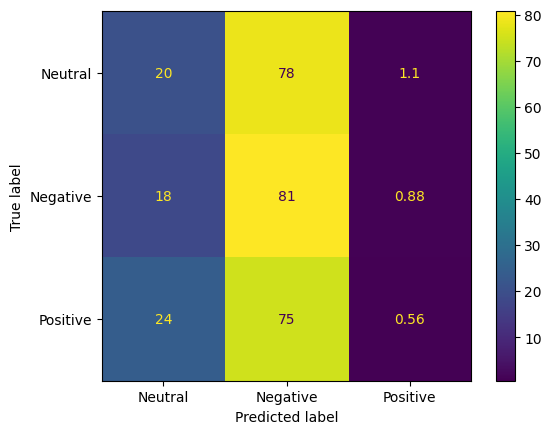

In [112]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {(100*accuracy):>0.2f}%\n')
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {(100*f1):>0.2f}%\n')

print('Confusion Matrix:')
classes = ['Neutral','Negative','Positive']
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix * 100, display_labels = [i for i in classes])
disp.plot()

### Results

*   By comparing the results of sections (2-1) and (2-2), it can be seen that using **"Domain Adaptation via Weakly Supervised Learning"** technique, the accuracy of the image model has been slightly improved on the labeled data.


*   In fact, the use of this technique is a kind of regularization that makes the image network, with the noisy labels of the text network, more generalizable.